In [54]:
import os
import cv2
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pyrealsense2 as rs 
print("Environment Ready")

Environment Ready


In [55]:
RECORDING_PATH = '../dataset/bags/cart_3_red_yellow.bag'
MASK_PATH = '../src/Mask_RCNN/datasets/process'

##  1. Open Recording

In [56]:
# Setup:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file(RECORDING_PATH)
profile = pipe.start(cfg)

# Skip 5 first frames to give the Auto-Exposure time to adjust
for x in range(5):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print("Frames Captured")

Frames Captured


## Get RGB data

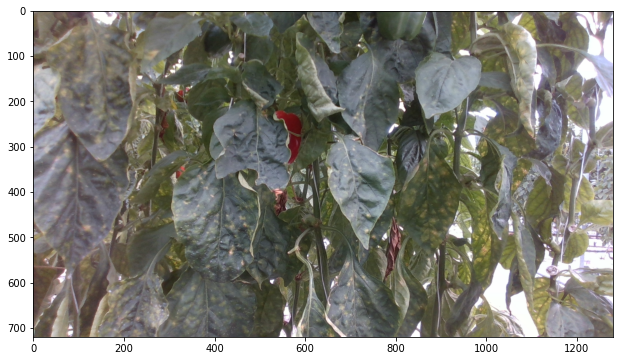

In [57]:
color = np.asanyarray(color_frame.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(color)

# Get Depth

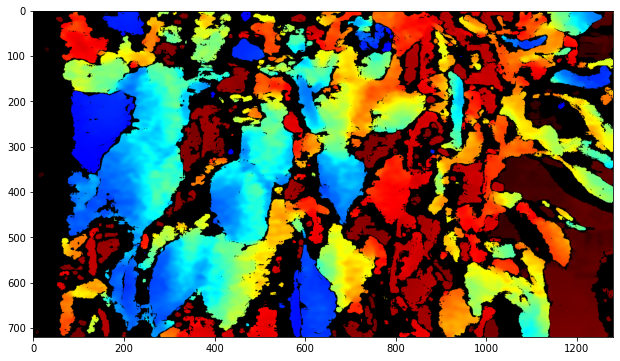

In [58]:
colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
plt.imshow(colorized_depth)

## Align Depth with color

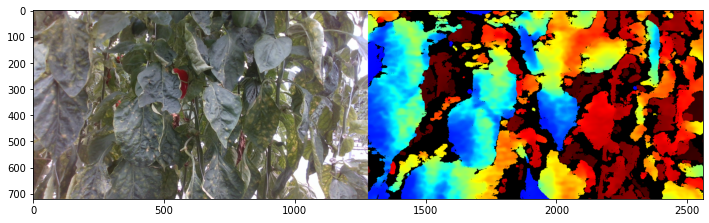

In [59]:

# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

# Show the two frames together:
images = np.hstack((color, colorized_depth))
plt.imshow(images)

## Saving Images

In [60]:
im = Image.fromarray(color)
im.save("frame.png")

## Reading bounding boxes from json

In [61]:
file_names = next(os.walk(MASK_PATH + '/boxes'))[2]
file_name = file_names[0]


In [62]:
data = []
with open(os.path.join(MASK_PATH + '/boxes/', file_name)) as json_file:
    data = json.load(json_file)
    data = np.array(data)

In [63]:
tmp_img = color.copy()

In [64]:
data[0]
expected = 1

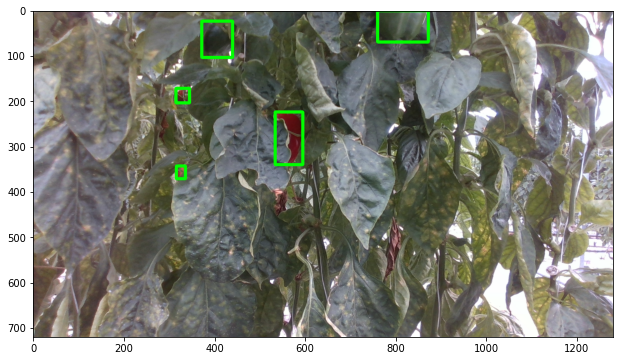

In [69]:
xmin = []
ymin = []
xmax = []
ymax = []

for box in data:
    xmin = box[1] 
    ymin = box[0] 
    xmax = box[3] 
    ymax = box[2]
    cv2.rectangle(tmp_img, (int(xmin * expected), int(ymin * expected)), (int(xmax * expected), int(ymax * expected)), (0, 255, 0), 5)

plt.imshow(tmp_img)

## Get depth data

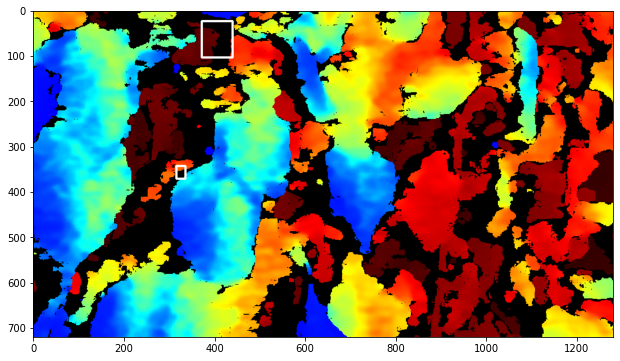

In [83]:
xmin = data[0][1] 
ymin = data[0][0] 
xmax = data[0][3] 
ymax = data[0][2]

xmin_depth = int((xmin * expected ) )
ymin_depth = int((ymin * expected) )
xmax_depth = int((xmax * expected ) )
ymax_depth = int((ymax * expected) )
xmin_depth,ymin_depth,xmax_depth,ymax_depth
cv2.rectangle(colorized_depth, (xmin_depth, ymin_depth), 
             (xmax_depth, ymax_depth), (255, 255, 255), 3)
plt.imshow(colorized_depth)

In [84]:

depth = np.asanyarray(aligned_depth_frame.get_data())


depth = depth[xmin_depth:xmax_depth,ymin_depth:ymax_depth].astype(float)

# Get data scale from the device and convert to meters
depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
depth = depth * depth_scale
dist,_,_,_ = cv2.mean(depth)
print("Detected a pepper {} meters away.".format(dist))

Detected a pepper 0.4902886262286355 meters away.
